In [ ]:
%pip install torchmetrics

In [ ]:
import os
import random
import torch
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import MulticlassAccuracy
import torch.optim as optim
from tqdm import tqdm
import time

# Dataset

In [ ]:
# Load dataset
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
val_ratio = 0.1
generator = torch.Generator().manual_seed(seed)
use_reduced_data = True

transform = transforms.Compose([
    transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-30, 30)),
    # transforms.ColorJitter(),
    transforms.RandAugment(num_ops=2, magnitude=7),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transformTest = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

CIFAR10Dataset = torchvision.datasets.CIFAR10(root='.', download=True)
full_train_dataset = torchvision.datasets.CIFAR10(root='.', train=True, download=True, transform=None)
test_dataset = torchvision.datasets.CIFAR10(root='.', train=False, download=True, transform=transformTest)

if use_reduced_data:
    total_reduced_size = 10000
    selected_indices = torch.randperm(len(full_train_dataset), generator=generator)[:total_reduced_size]
else:
    selected_indices = torch.arange(len(full_train_dataset))

val_size = int(len(selected_indices) * val_ratio)
train_size = len(selected_indices) - val_size
train_indices, val_indices = random_split(selected_indices, [train_size, val_size], generator=generator)


train_dataset = Subset(
    torchvision.datasets.CIFAR10(root='.', train=True, download=False, transform=transform),
    train_indices.indices
)

val_dataset = Subset(
    torchvision.datasets.CIFAR10(root='.', train=True, download=False, transform=transformTest),
    val_indices.indices
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=os.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count())
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count())

# Small CNN model

In [ ]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*8*64, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [ ]:
from torchinfo import summary

In [ ]:
model = SmallCNN(num_classes=10)
summary(model, input_size=(1, 3, 32, 32))


Layer (type:depth-idx)                   Output Shape              Param #
SmallCNN                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 8, 8]             --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           896
│    └─BatchNorm2d: 2-2                  [1, 32, 32, 32]           64
│    └─ReLU: 2-3                         [1, 32, 32, 32]           --
│    └─MaxPool2d: 2-4                    [1, 32, 16, 16]           --
│    └─Conv2d: 2-5                       [1, 64, 16, 16]           18,496
│    └─BatchNorm2d: 2-6                  [1, 64, 16, 16]           128
│    └─ReLU: 2-7                         [1, 64, 16, 16]           --
│    └─MaxPool2d: 2-8                    [1, 64, 8, 8]             --
├─Sequential: 1-2                        [1, 10]                   --
│    └─Flatten: 2-9                      [1, 4096]                 --
│    └─Linear: 2-10                      [1, 512]                  2,097,664
│ 

# Train and Validation

In [ ]:
def train(model, train_loader, val_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    model.to(device)
    results = []
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        start_time = time.time()

        for inputs, labels in (train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        val_acc, val_loss = validation(model, val_loader, device, show_metrics=False)
        scheduler.step()
        # print(f'Learning Rate: {scheduler.get_last_lr()[-1]:0.4e}')
        print(f"Epoch {epoch+1}/{epochs}({time.time() - start_time:.2f}s)  - accuracy: {train_acc:.4f}  - loss: {train_loss:.4f}  - val_accuracy: {val_acc:.4f}  - val_loss: {val_loss:.4f}")
        results.append([train_acc, train_loss, val_acc, val_loss])
    return results

def validation(model, test_loader, device, show_metrics=True):
    metric = MulticlassAccuracy(num_classes=10).to(device)
    model.eval()
    model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in (test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            metric.update(outputs, labels)
            total_loss += loss.item()

    accuracy_val = metric.compute().item()
    avg_loss = total_loss / len(test_loader)

    if show_metrics:
        print(f"Validation Accuracy: {accuracy_val:.4f} Loss: {avg_loss:.4f}")
    return accuracy_val, avg_loss


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 20
learning_rate = 1e-3
model = SmallCNN().to(device)

history = train(model, train_loader, val_loader, epochs, learning_rate, device)

Epoch 1/20(15.32s)  - accuracy: 0.3169  - loss: 1.9550  - val_accuracy: 0.4679  - val_loss: 1.6284
Epoch 2/20(9.18s)  - accuracy: 0.4080  - loss: 1.7707  - val_accuracy: 0.4590  - val_loss: 1.6492
Epoch 3/20(9.18s)  - accuracy: 0.4441  - loss: 1.7050  - val_accuracy: 0.5437  - val_loss: 1.4994
Epoch 4/20(9.14s)  - accuracy: 0.4689  - loss: 1.6456  - val_accuracy: 0.5651  - val_loss: 1.4357
Epoch 5/20(8.21s)  - accuracy: 0.4938  - loss: 1.6033  - val_accuracy: 0.5789  - val_loss: 1.4225
Epoch 6/20(9.15s)  - accuracy: 0.5086  - loss: 1.5738  - val_accuracy: 0.5635  - val_loss: 1.4243
Epoch 7/20(9.06s)  - accuracy: 0.5187  - loss: 1.5549  - val_accuracy: 0.5916  - val_loss: 1.3947
Epoch 8/20(8.17s)  - accuracy: 0.5341  - loss: 1.5205  - val_accuracy: 0.6021  - val_loss: 1.3566
Epoch 9/20(9.17s)  - accuracy: 0.5420  - loss: 1.5018  - val_accuracy: 0.6194  - val_loss: 1.3534
Epoch 10/20(9.09s)  - accuracy: 0.5551  - loss: 1.4759  - val_accuracy: 0.6177  - val_loss: 1.3155
Epoch 11/20(8.07s)

In [ ]:
validation(model, test_loader, device)

Validation Accuracy: 0.6746 Loss: 1.2392


(0.6746000647544861, 1.239183881480223)

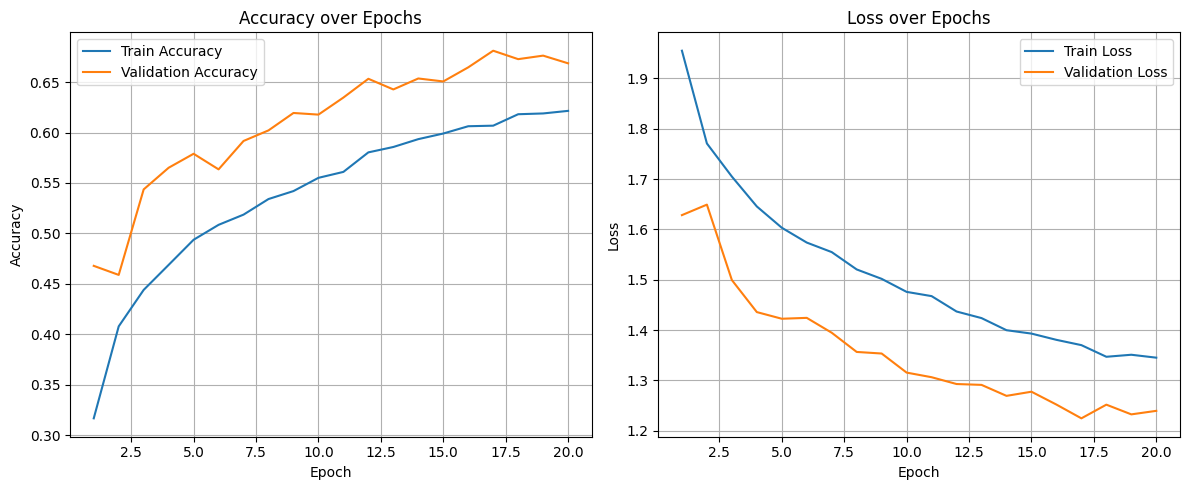

In [ ]:
import matplotlib.pyplot as plt

# Unpack the history
train_acc = [row[0] for row in history]
train_loss = [row[1] for row in history]
val_acc   = [row[2] for row in history]
val_loss  = [row[3] for row in history]
epochs = range(1, len(history) + 1)

# Plotting
plt.figure(figsize=(12, 5))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

# Subplot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
